# **Importing the Data**

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
import os
import multiprocessing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# For Barouyr
#data1 = pd.read_csv("BETN073-1990_2012.csv")
#data2 = pd.read_csv("BETN073-2013_2022.csv")
#ozone_data = pd.concat([data1,data2])
#ozone_data = ozone_data.reset_index()

In [72]:
# For Luis
data1 = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/BETN073-1990_2012.csv")
data2 = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/BETN073-2013_2022.csv")
ozone_data = pd.concat([data1,data2])
ozone_data = ozone_data.reset_index()

# **Preprocessing**

Select the data where that will be used for the model which includes the hourly data from 2008 to 2019. The unnecessary columns are moved to only keep the columns with concentration values and the date and time at which each concentration is measured.

## Making Concentration values NA for validity = 0 and validity = 1

In [73]:
ozone_data.head()

,index,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,0,BE/SPO-BETN073_00007_100,7,1990-01-01T00:00:00,1990-01-01T01:00:00,47.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
1,1,BE/SPO-BETN073_00007_100,7,1990-01-01T01:00:00,1990-01-01T02:00:00,46.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
2,2,BE/SPO-BETN073_00007_100,7,1990-01-01T02:00:00,1990-01-01T03:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
3,3,BE/SPO-BETN073_00007_100,7,1990-01-01T03:00:00,1990-01-01T04:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
4,4,BE/SPO-BETN073_00007_100,7,1990-01-01T04:00:00,1990-01-01T05:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN


In [74]:
ozone_data['Validity'].unique()

array([ 1, -1,  0])

In [75]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [76]:
# Check rows with Validity = 0 or Validity = -1 and set Value to NaN
ozone_data.loc[(ozone_data['Validity'] == 0) | (ozone_data['Validity'] == -1), 'Value'] = None

In [77]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [78]:
columns_remove = ['Samplingpoint','Pollutant','End','Unit','AggType','Validity','Verification','ResultTime','DataCapture','FkObservationLog','index']
ozone_data = ozone_data.drop(columns=columns_remove)

# Sampling Point: BE/SPO-BETN073_00007_100
# Pollutant: 7 (O_3)
# End: Start with 1 hour added
# Unit: ug.m-3
# Aggregation Type: hour
# Validaity/Verification: 1 & 1
# Result Time: Time and Date when data is added to the whole data file
# Data Capture: 0
# FkObservation log: Do not know meaning, values from NaN to 0fa5da4d-ae92-4bb7-bcd4-07fb6b962ae4

ozone_data['Start'] = pd.to_datetime(ozone_data['Start'])
data = ozone_data[(ozone_data['Start'].dt.year >= 2007) & (ozone_data['Start'].dt.year <= 2019)]
data = data.reset_index()
data = data.drop(columns=['index'])
data.rename(columns={'Value': 'Concentration'}, inplace=True)

Thus the following dataframe only

In [79]:
data.head()

,Start,Concentration
0,2007-01-01 00:00:00,59.0
1,2007-01-01 01:00:00,NaN
2,2007-01-01 02:00:00,63.0
3,2007-01-01 03:00:00,60.0
4,2007-01-01 04:00:00,68.0


The data is checked to make sure there are no duplicates.

In [80]:
duplicates = data.duplicated(subset=['Start'])

# Print or further process the duplicate values
print("Duplicate values in the column Start:", duplicates.any())

Duplicate values in the column Start: False


## Adding new variables

From the Start column, we extracr the year, month, day and time.

In [81]:
# Extract year, month, day, and time into separate columns
data['Year'] = data['Start'].dt.year
data['Month'] = data['Start'].dt.month
data['Day'] = data['Start'].dt.day
data['Time'] = data['Start'].dt.time

# Display the transformed DataFrame
print(data.head())

                Start  Concentration  Year  Month  Day      Time
0 2007-01-01 00:00:00           59.0  2007      1    1  00:00:00
1 2007-01-01 01:00:00            NaN  2007      1    1  01:00:00
2 2007-01-01 02:00:00           63.0  2007      1    1  02:00:00
3 2007-01-01 03:00:00           60.0  2007      1    1  03:00:00
4 2007-01-01 04:00:00           68.0  2007      1    1  04:00:00


From the Start column the day of the week can be extracted, which can also be used to determine if that measurement was taken during the weekend.

In [82]:
# Extract day of the week
data['DayOfWeek'] = (data['Start'].dt.weekday + 1) % 7

# Create a new column indicating whether the day is a weekend or not
data['Weekend'] = (data['Start'].dt.dayofweek // 5).astype(int)

In [83]:
data.head()

,Start,Concentration,Year,Month,Day,Time,DayOfWeek,Weekend
0,2007-01-01 00:00:00,59.0,2007,1,1,00:00:00,1,0
1,2007-01-01 01:00:00,NaN,2007,1,1,01:00:00,1,0
2,2007-01-01 02:00:00,63.0,2007,1,1,02:00:00,1,0
3,2007-01-01 03:00:00,60.0,2007,1,1,03:00:00,1,0
4,2007-01-01 04:00:00,68.0,2007,1,1,04:00:00,1,0


## Converting the negative values

Missing values are represented by negative concentration values. Thus, these will be converted to NaN to be able to used the describe function to attain some basic measures.

In [84]:
# Can check the issue here
data['Concentration'].describe()

count    107279.000000
mean         44.754053
std          28.892237
min           0.000000
25%          23.000000
50%          43.500000
75%          62.000000
max         238.000000
Name: Concentration, dtype: float64

In [85]:
count_below_zero = (data['Concentration'] < 0).sum()

# Print the count
print("Number of observations with values below 0:", count_below_zero)

data.loc[data['Concentration'] < 0, 'Concentration'] = np.nan

Number of observations with values below 0: 0


In [86]:
data['Concentration'].isna().sum()

5976

Thus, there are 5976 missing observation for the BETN073 station between the years 2007 and 2019.

In [87]:
data['Concentration'].describe()

count    107279.000000
mean         44.754053
std          28.892237
min           0.000000
25%          23.000000
50%          43.500000
75%          62.000000
max         238.000000
Name: Concentration, dtype: float64

## Making the data daily, using 8 hour Mean Max



In [88]:
# Calculate the 8-hour rolling mean
eight_hour_rolling_mean = data.groupby(['Year', 'Month', 'Day'])['Concentration'].rolling(window=8).mean().reset_index(drop=True)

# Add the 8-hour rolling mean as a new column in the original DataFrame
data['EightHourRollingMean'] = eight_hour_rolling_mean

# Group by 'Year', 'Month', and 'Day', and find the daily maximum of the 8-hour mean
data = data.groupby(['Year', 'Month', 'Day']).agg({'EightHourRollingMean': 'max', 'DayOfWeek': 'first', 'Weekend': 'first'}).reset_index()

In [89]:
data.rename(columns={'EightHourRollingMean': 'Concentration'}, inplace=True)

In [90]:
data

,Year,Month,Day,Concentration,DayOfWeek,Weekend
0,2007,1,1,71.2500,1,0
1,2007,1,2,52.6250,2,0
2,2007,1,3,53.2500,3,0
3,2007,1,4,54.0000,4,0
4,2007,1,5,53.2500,5,0
...,...,...,...,...,...,...
4714,2019,12,27,45.2500,5,0
4715,2019,12,28,42.1250,6,1
4716,2019,12,29,32.8750,0,1
4717,2019,12,30,41.6875,1,0


In [91]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 92


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4719 entries, 0 to 4718
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4719 non-null   int32  
 1   Month          4719 non-null   int32  
 2   Day            4719 non-null   int32  
 3   Concentration  4627 non-null   float64
 4   DayOfWeek      4719 non-null   int32  
 5   Weekend        4719 non-null   int64  
dtypes: float64(1), int32(4), int64(1)
memory usage: 147.6 KB


In [93]:
# Check for NaN values in the entire DataFrame
nan_rows = data[data.isna().any(axis=1)]

# Print the rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
      Year  Month  Day  Concentration  DayOfWeek  Weekend
95    2007      4    6            NaN          5        0
97    2007      4    8            NaN          0        1
98    2007      4    9            NaN          1        0
99    2007      4   10            NaN          2        0
100   2007      4   11            NaN          3        0
...    ...    ...  ...            ...        ...      ...
4417  2019      3    5            NaN          2        0
4418  2019      3    6            NaN          3        0
4419  2019      3    7            NaN          4        0
4420  2019      3    8            NaN          5        0
4478  2019      5    5            NaN          0        1

[92 rows x 6 columns]


In [94]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

data.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend
Date,,,,,,
2007-01-01,2007,1,1,71.250,1,0
2007-01-02,2007,1,2,52.625,2,0
2007-01-03,2007,1,3,53.250,3,0
2007-01-04,2007,1,4,54.000,4,0
2007-01-05,2007,1,5,53.250,5,0


# **ARIMA model**

## A new variable based on the optimal SARIMA is made

In [95]:
### We first create a new dataset,interpolate the missing values so that we can perform ARIMA
# Assuming data is your DataFrame
data_a = data.copy()

In [96]:
data_a['Concentration'] = data_a['Concentration'].interpolate(method='linear')

In [97]:
# Assuming data_a is your DataFrame
columns_to_drop = ['Year', 'Month', 'Day', 'DayOfWeek', 'Weekend']

# Drop the specified columns from data_a
data_a = data_a.drop(columns=columns_to_drop)

data_a.isna().sum()
data_a.head()

,Concentration
Date,
2007-01-01,71.250
2007-01-02,52.625
2007-01-03,53.250
2007-01-04,54.000
2007-01-05,53.250


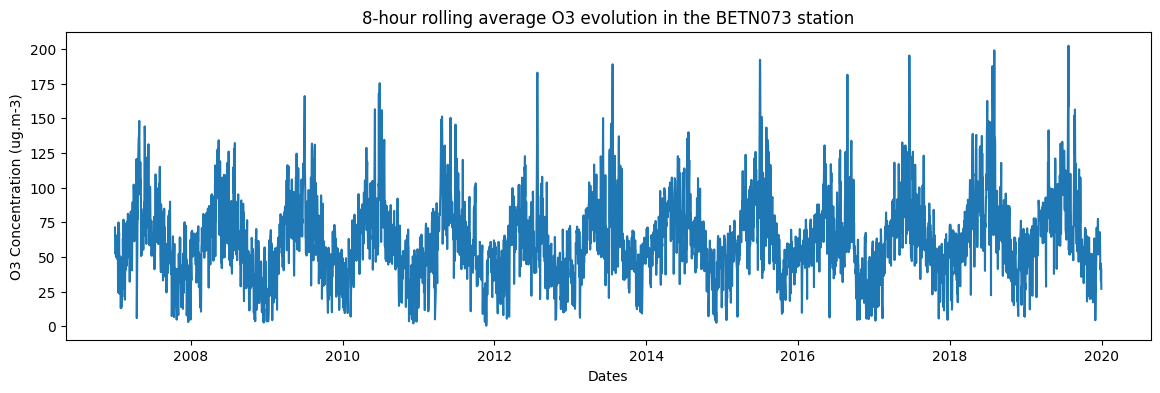

In [98]:
plt.figure(figsize=(14,4))
plt.title('8-hour rolling average O3 evolution in the BETN073 station')
plt.xlabel('Dates')
plt.ylabel('O3 Concentration (ug.m-3)')
plt.plot(data_a.Concentration)

In [99]:
data_b = data_a.copy()
data_b = data_b.reset_index()

In [100]:
data_b

,Date,Concentration
0,2007-01-01,71.2500
1,2007-01-02,52.6250
2,2007-01-03,53.2500
3,2007-01-04,54.0000
4,2007-01-05,53.2500
...,...,...
4714,2019-12-27,45.2500
4715,2019-12-28,42.1250
4716,2019-12-29,32.8750
4717,2019-12-30,41.6875


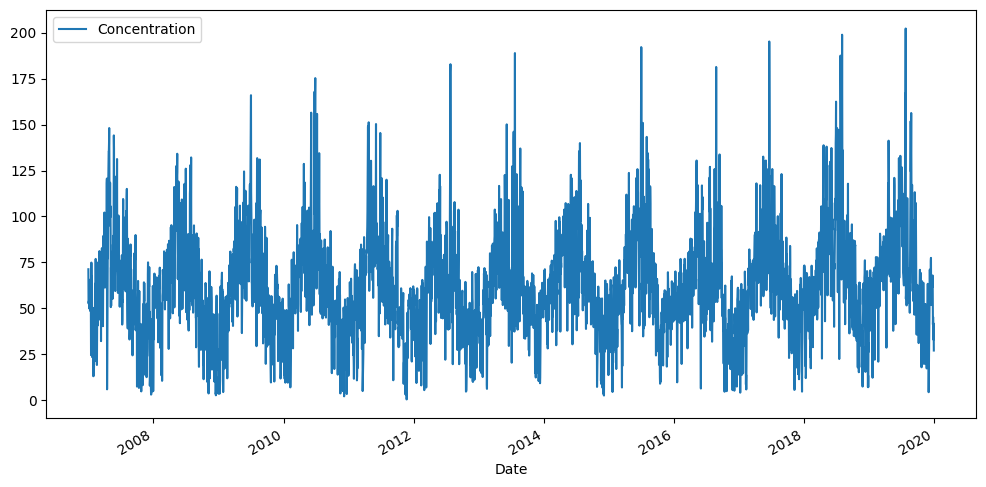

In [101]:
data_b['Date'] = pd.to_datetime(data_b['Date'])  # Convert date column to DateTime
ax = data_b.plot(x='Date', y='Concentration', figsize=(12, 6))

plt.show()

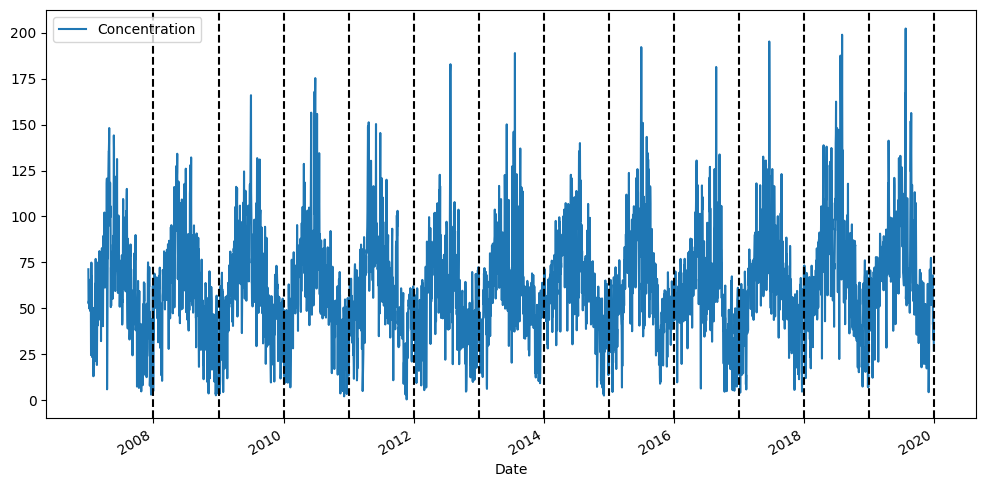

In [102]:
ax = data_b.plot(x='Date', y='Concentration', figsize=(12,6))
xcoords = ['2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

We can slightly observe seasonality

In [103]:
data_a.dropna(subset=['Concentration'], inplace=True)

In [104]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data_a)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -5.472084325704644
p-value: 2.386197933339654e-06
Critical Values: {'1%': -3.4317441786539846, '5%': -2.862156067337046, '10%': -2.5670979349139214}
The time series is likely stationary.


## Analysed stationarity

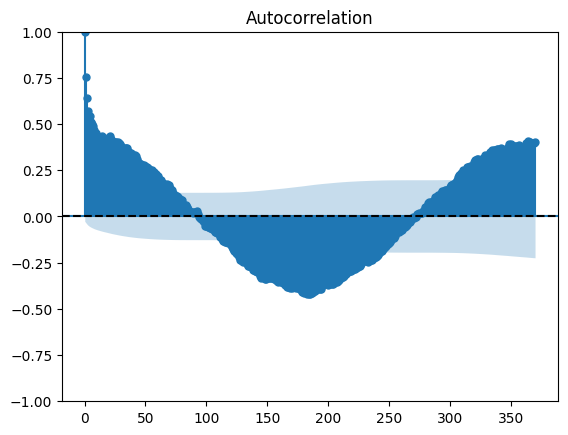

In [105]:
acf_plot = plot_acf(data_a.Concentration, lags=370)
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

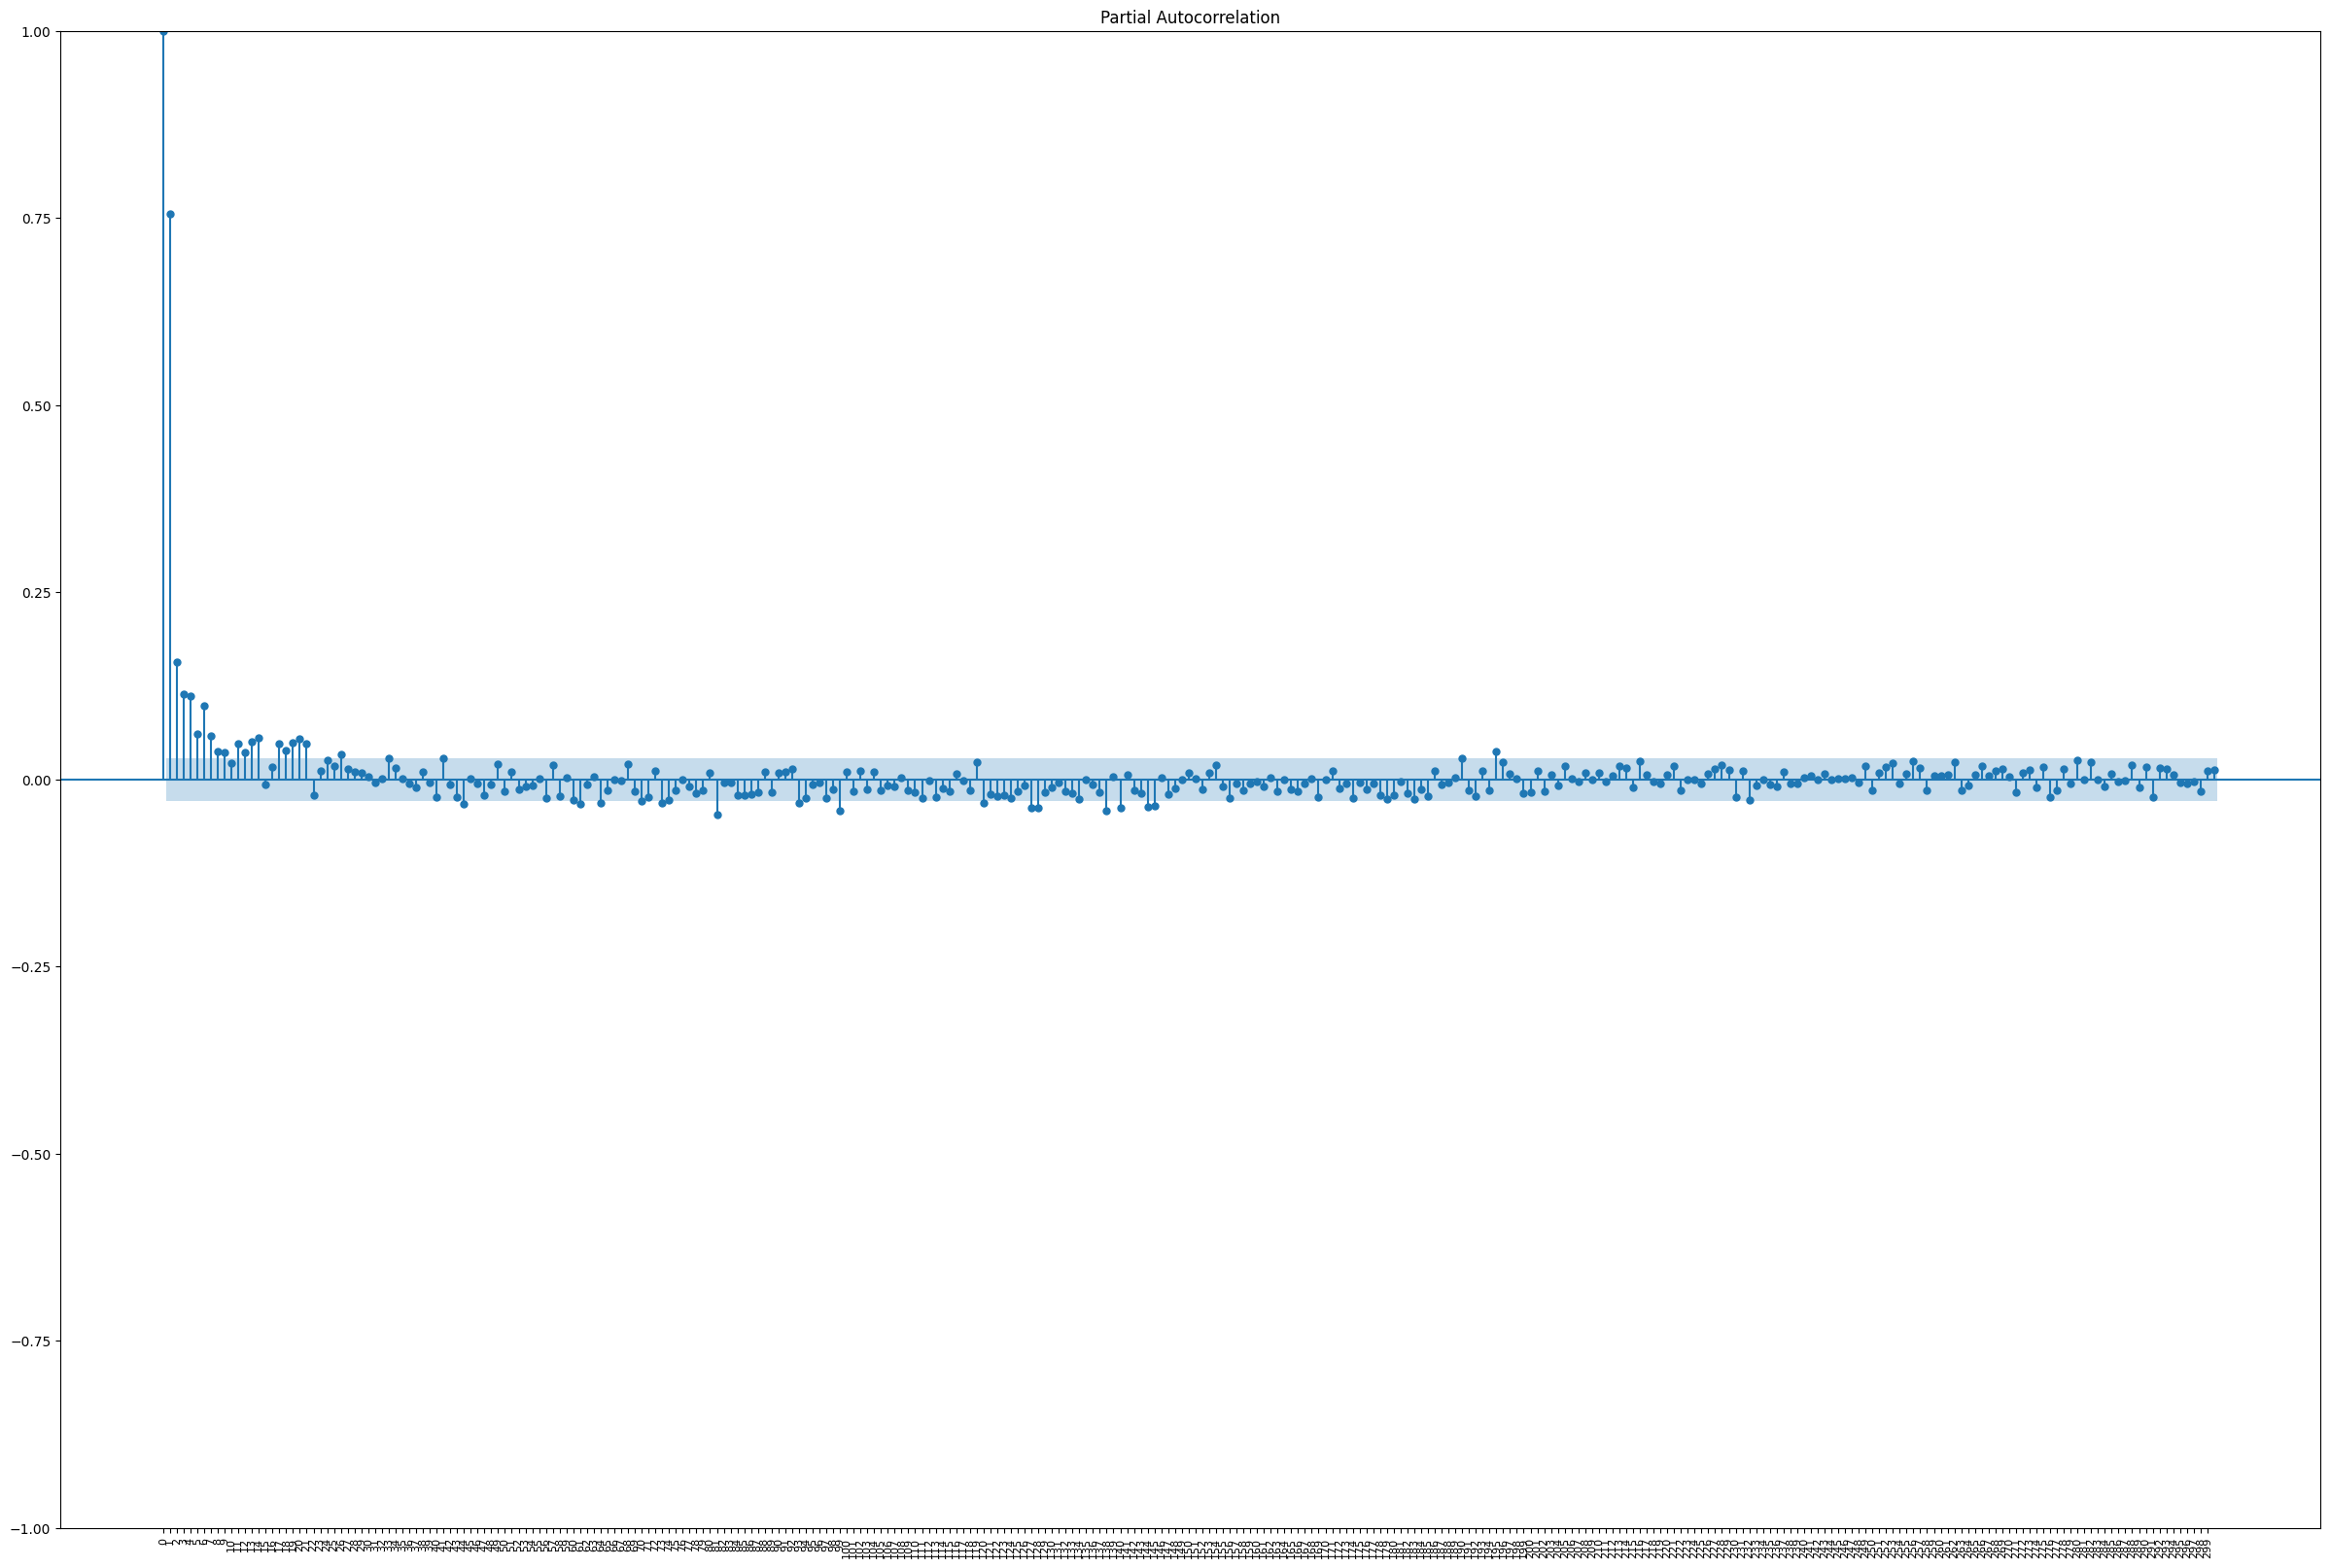

In [106]:
# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(30, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(data_a['Concentration'], lags=300, ax=ax)

# Display the plot
plt.xticks(range(300), rotation='vertical', fontsize=8)
plt.show()



# Define the range of AR, MA, and seasonality values to check
ar_range = range(12)
ma_range = range(12)

# Initialize variables for tracking the best model
best_mse = float('inf')
best_order = None
best_results = None

# Iterate through AR and MA values
for p in ar_range:
    for q in ma_range:
        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA
        model = sm.tsa.ARIMA(data_a['Concentration'], order=order)
        results = model.fit()

        # Calculate Mean Squared Error (MSE)
        fitted_values = results.fittedvalues
        mse = mean_squared_error(data_a['Concentration'], fitted_values)

        # Check if the current model has a lower MSE than the best so far
        if mse < best_mse:
            best_mse = mse
            best_order = order
            best_results = results

# Display the best model's information including AIC, BIC, MSE, and summary
print(f'Best Model Order: {best_order}')
print(f'Best Model AIC: {best_results.aic:.2f}')
print(f'Best Model BIC: {best_results.bic:.2f}')
print(f'Best Model MSE: {best_mse:.2f}')
print(best_results.summary())


In [107]:
# Fit ARMA (10, 0, 11)
order_arma = (10, 0, 11)  # ARIMA order (p, d, q), here d=0 for ARMA
model_arma = sm.tsa.ARIMA(data_a['Concentration'], order=order_arma)
results_arma = model_arma.fit()

# Extract the predicted (fitted) values
fitted_values = pd.DataFrame({
    'FittedValues': results_arma.fittedvalues
})

# Combine the original data_a DataFrame with the fitted values
data['FittedValues'] = fitted_values['FittedValues']

# Display the updated DataFrame
print(data)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues
Date                                                                         
2007-01-01  2007      1    1        71.2500          1        0     62.781033
2007-01-02  2007      1    2        52.6250          2        0     68.990263
2007-01-03  2007      1    3        53.2500          3        0     57.821090
2007-01-04  2007      1    4        54.0000          4        0     57.160022
2007-01-05  2007      1    5        53.2500          5        0     57.110534
...          ...    ...  ...            ...        ...      ...           ...
2019-12-27  2019     12   27        45.2500          5        0     49.119100
2019-12-28  2019     12   28        42.1250          6        1     51.319607
2019-12-29  2019     12   29        32.8750          0        1     47.292298
2019-12-30  2019     12   30        41.6875          1        0     41.426066
2019-12-31  2019     12   31        27.0000          2        0 

Model not valid, as Ljung test is 0.02. lower than 0.05.

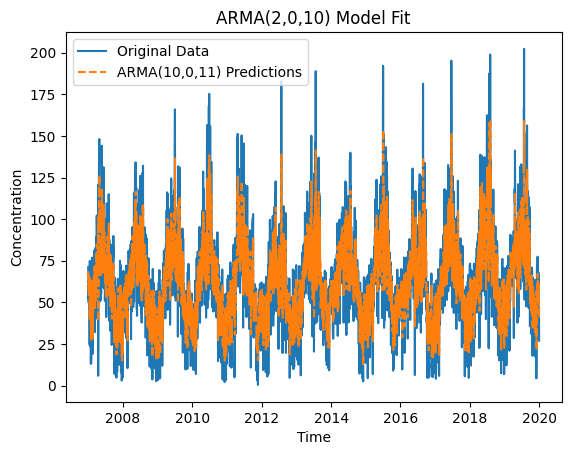

In [108]:
# Plot original data and predicted values
plt.plot(data_a, label='Original Data')
plt.plot(results_arma.fittedvalues, label='ARMA(10,0,11) Predictions', linestyle='--')
plt.title('ARMA(2,0,10) Model Fit')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

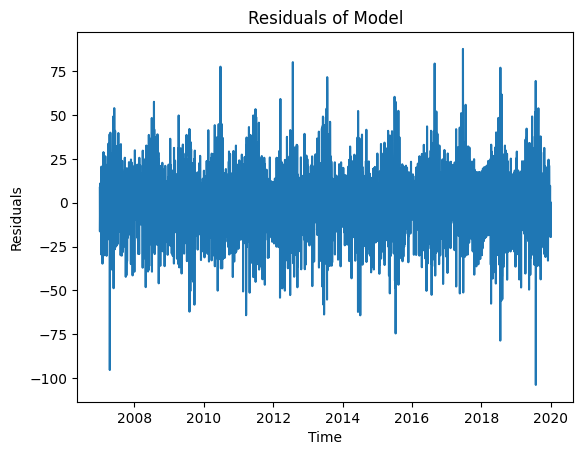

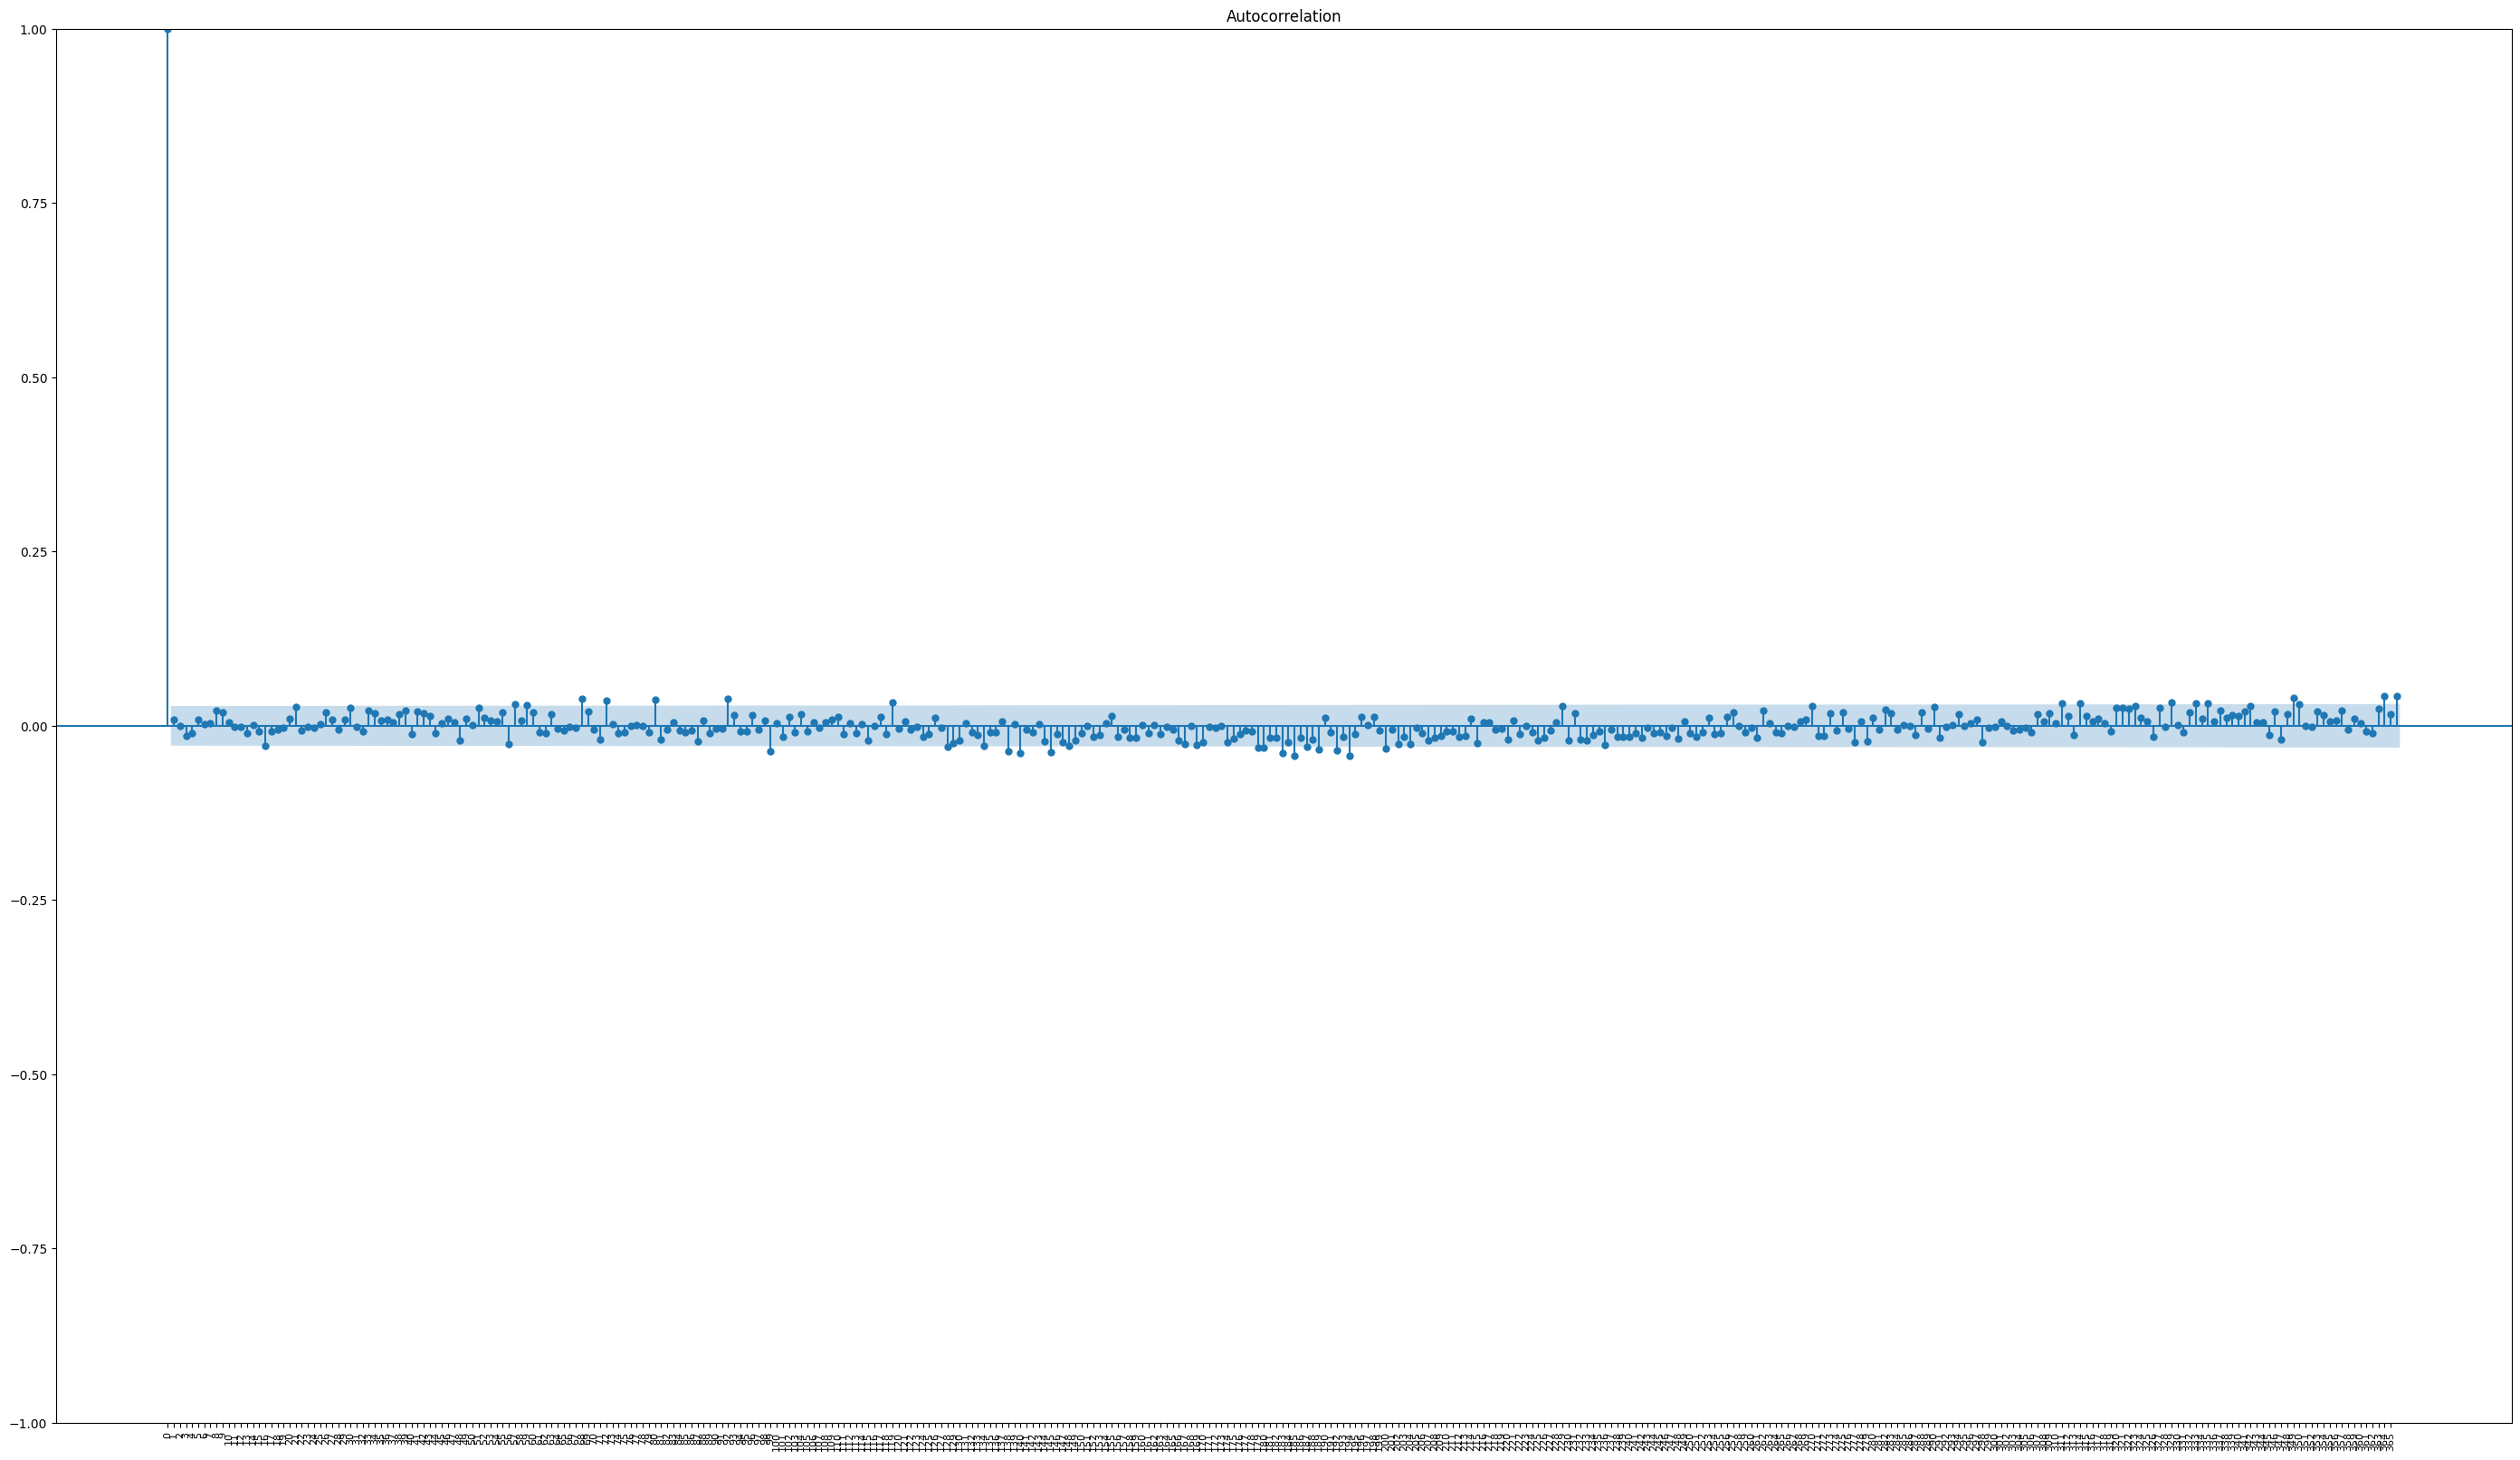

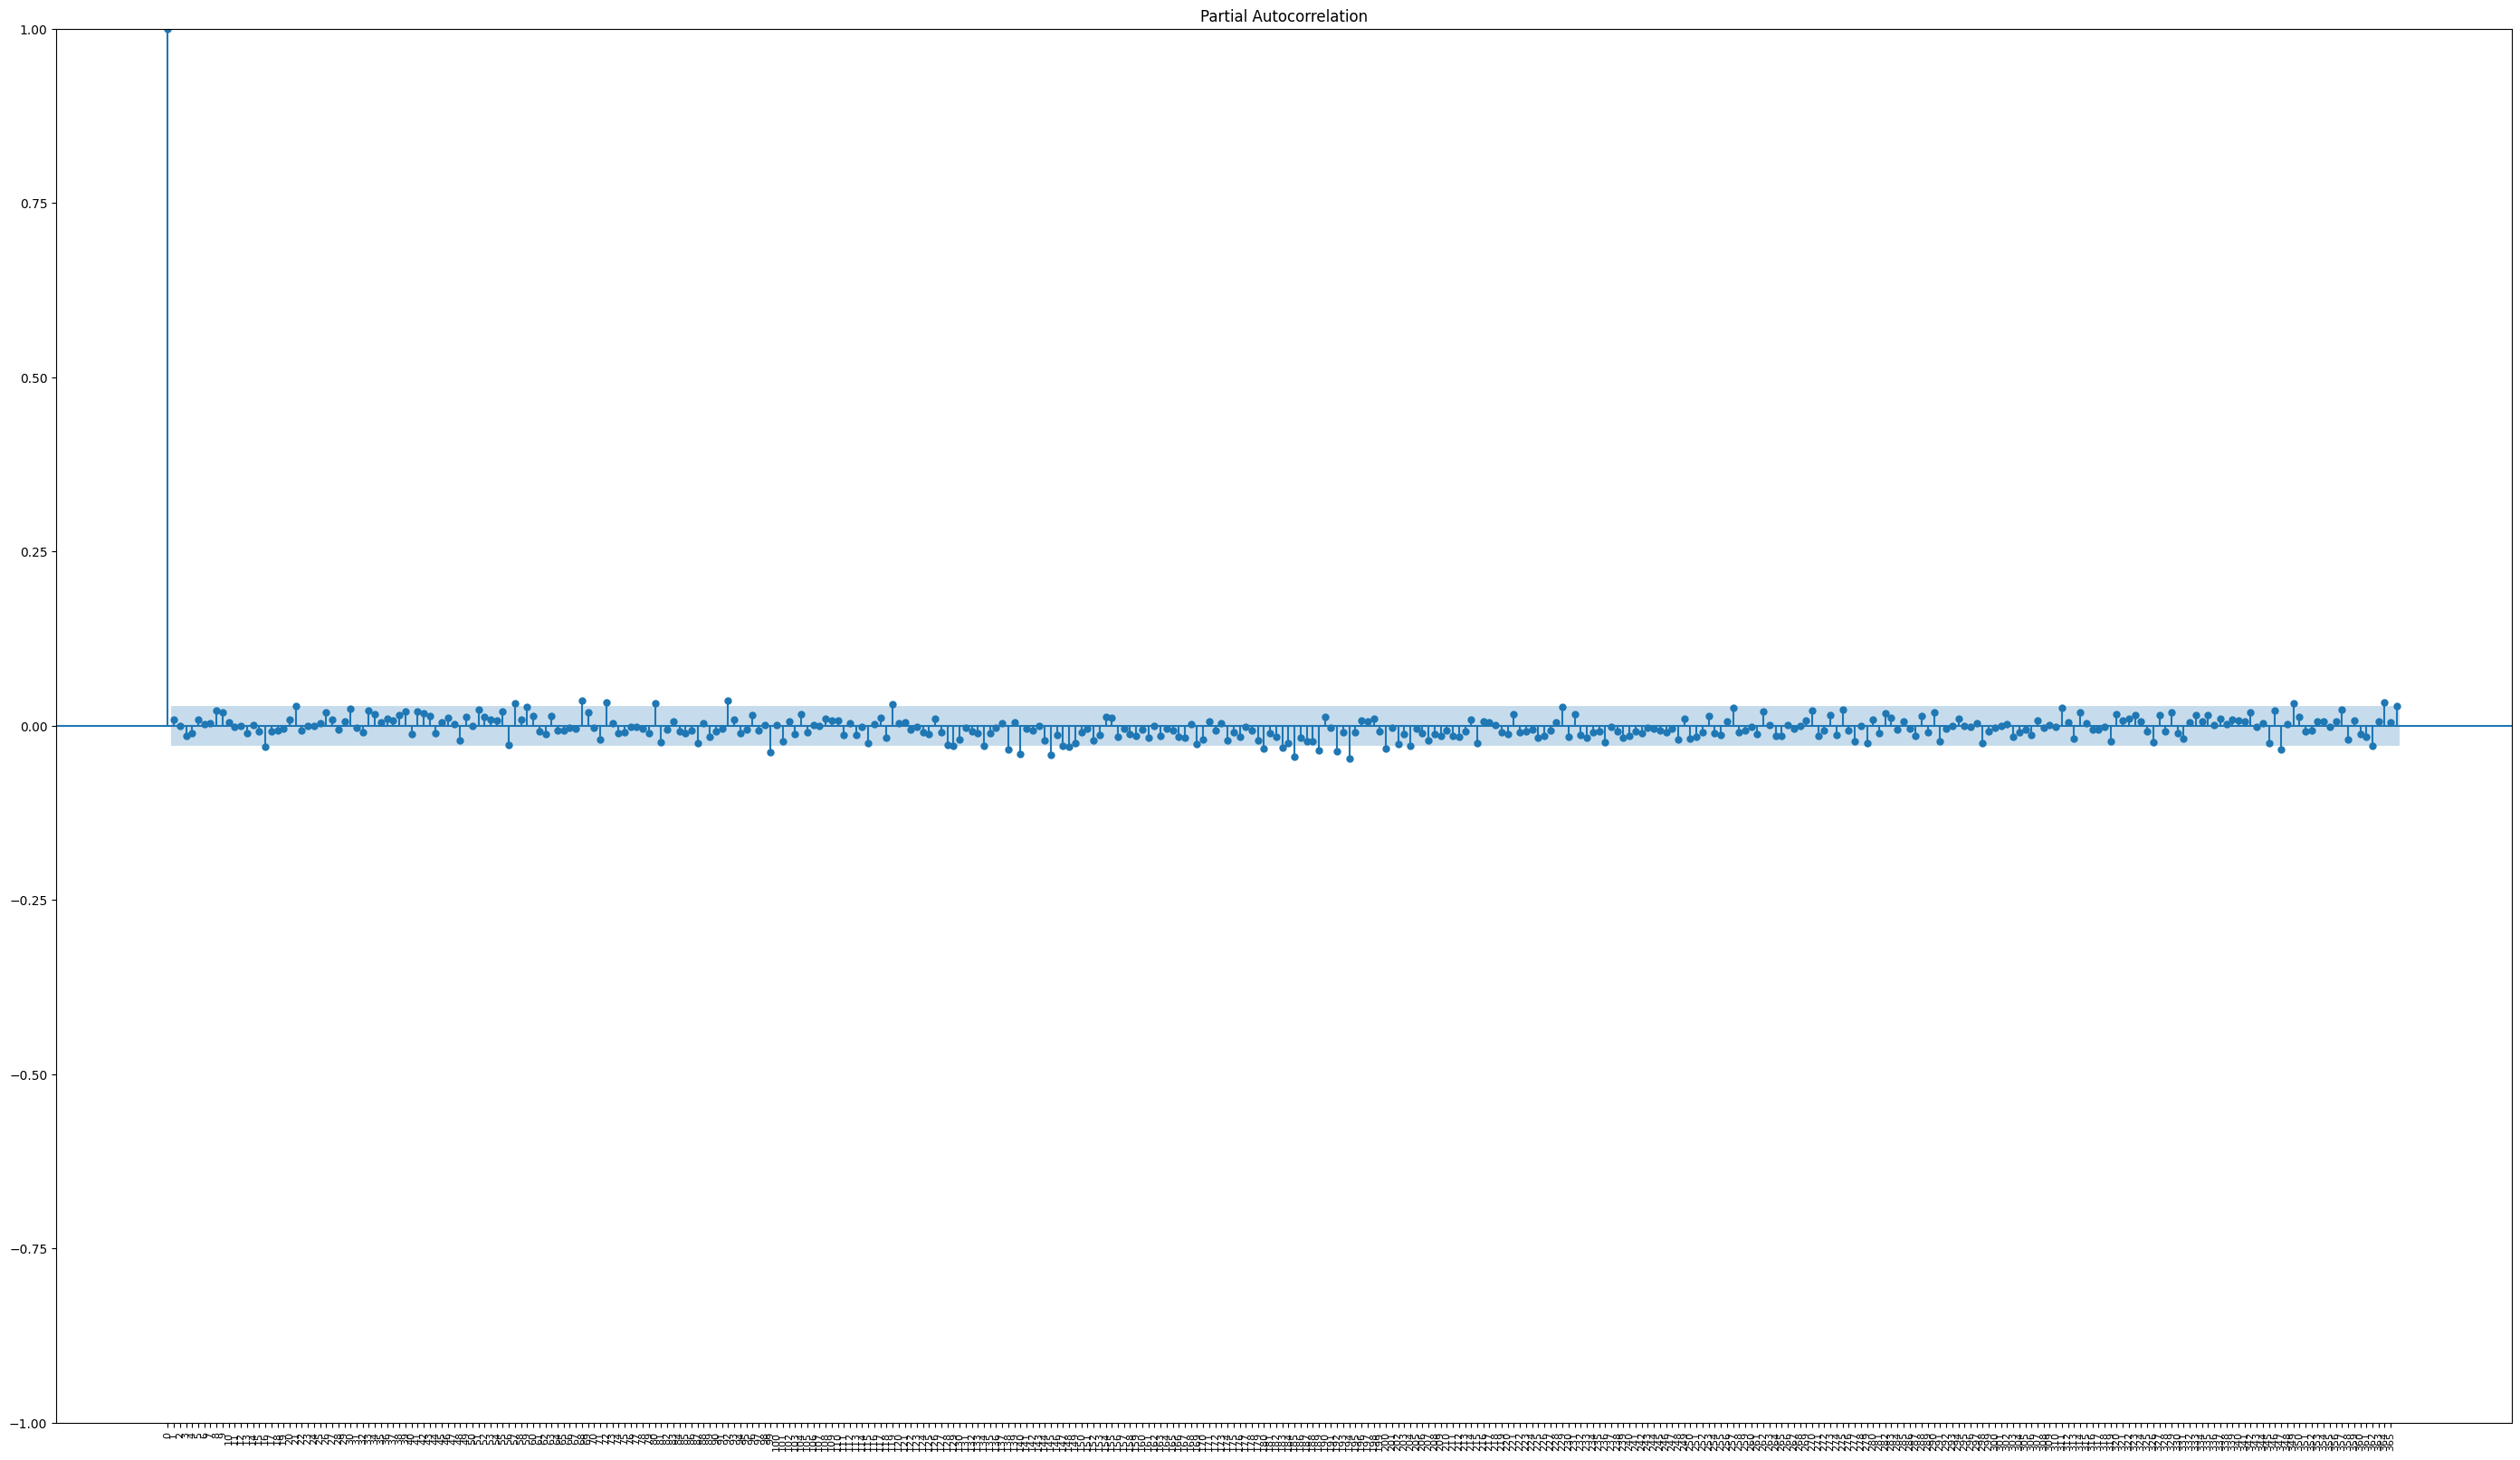

In [109]:
residuals = results_arma.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals of Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
acf_plot = plot_acf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()


# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()

In [110]:
# Remove NaN values from 'Concentration' and 'FittedValues' columns
mask = ~np.isnan(data['Concentration']) & ~np.isnan(data['FittedValues'])
y_true = data['Concentration'][mask]
y_pred = data['FittedValues'][mask]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 308.20


The MSE is very high, its 308.20

## Now we calculate the lagged values of Concentration (making a new variable with the value from day before, a week before, a month before, and a year before)

In [111]:
# Assuming 'Date' is your index
data['day_lag1'] = data['Concentration'].shift(1)
data['day_lag7'] = data['Concentration'].shift(7)
data['day_fut1'] = data['Concentration'].shift(-1)
data['day_fut7'] = data['Concentration'].shift(-7)

# If 'Date' is not the index, you can use the following instead
# data['day_lag1'] = data['Concentration'].shift(1).reset_index(drop=True)

print(data.head())

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2007-01-01  2007      1    1         71.250          1        0     62.781033   
2007-01-02  2007      1    2         52.625          2        0     68.990263   
2007-01-03  2007      1    3         53.250          3        0     57.821090   
2007-01-04  2007      1    4         54.000          4        0     57.160022   
2007-01-05  2007      1    5         53.250          5        0     57.110534   

            day_lag1  day_lag7  day_fut1  day_fut7  
Date                                                
2007-01-01       NaN       NaN    52.625    60.875  
2007-01-02    71.250       NaN    53.250    60.375  
2007-01-03    52.625       NaN    54.000    61.000  
2007-01-04    53.250       NaN    53.250    61.125  
2007-01-05    54.000       NaN    49.875    48.500  


In [112]:
# Assuming data is your DataFrame
data['day_lag30'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year']) &
        (data['Month'] == row['Month'] - 1) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Month'] > 1 and not data.loc[
        (data['Year'] == row['Year']) &
        (data['Month'] == row['Month'] - 1) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

data['day_lag365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

data['day_fut365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] + 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] + 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

In [113]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', 'day_lag365', 'day_fut365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for day_lag1 with dropped values: 415.13181017067944
MSE for day_lag7 with dropped values: 827.8187394356036
MSE for day_fut1 with dropped values: 409.131392748186
MSE for day_fut7 with dropped values: 851.9662068148087
MSE for day_lag30 with dropped values: 1032.219632513605
MSE for day_lag365 with dropped values: 927.9470594904353
MSE for day_fut365 with dropped values: 943.1290698693107


# Extra PreProc

## Introduction of Holiday variable

In [114]:
# List of holiday dates with months and days
holiday_dates = {
    (1, 1),   # New Year's Day
    (1, 6),   # Epiphany
    (2, 14),  # Valentine's Day
    (3, 20),  # March Equinox
    (3, 29),  # Good Friday
    (3, 31),  # Easter Sunday
    (4, 1),   # Easter Monday
    (5, 1),   # Labor Day / May Day
    (5, 8),   # Iris Day (Brussels Regional holiday)
    (5, 9),   # Ascension Day
    (5, 10),  # Day after Ascension Day
    (5, 12),  # Mothers' Day
    (5, 19),  # Whit Sunday
    (5, 20),  # Whit Monday
    (6, 9),   # Fathers' Day
    (6, 20),  # June Solstice
    (7, 11),  # Day of the Flemish Community (Regional holiday in some provinces)
    (7, 21),  # Belgian National Day
    (8, 15),  # Assumption of Mary
    (9, 15),  # Day of the Walloon Region (Regional holiday in Namur)
    (9, 22),  # September Equinox
    (9, 27),  # Day of the French Community (Regional holiday in some provinces)
    (10, 27), # Daylight Saving Time ends
    (10, 31), # Halloween
    (11, 1),  # All Saints' Day
    (11, 11), # Armistice Day
    (11, 15), # Day of the German-speaking Community (Regional holiday in Liège)
    (12, 6),  # St. Nicholas Day
    (12, 21), # December Solstice
    (12, 24), # Christmas Eve
    (12, 25), # Christmas Day
    (12, 26), # Boxing Day
    (12, 31)  # New Year's Eve
}

# Create a new column 'IsHoliday' and set it to 1 for holidays, 0 otherwise
data['IsHoliday'] = data.apply(lambda row: 1 if (row['Month'], row['Day']) in holiday_dates else 0, axis=1)

# Display the updated DataFrame
print(data)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2007-01-01  2007      1    1        71.2500          1        0     62.781033   
2007-01-02  2007      1    2        52.6250          2        0     68.990263   
2007-01-03  2007      1    3        53.2500          3        0     57.821090   
2007-01-04  2007      1    4        54.0000          4        0     57.160022   
2007-01-05  2007      1    5        53.2500          5        0     57.110534   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27        45.2500          5        0     49.119100   
2019-12-28  2019     12   28        42.1250          6        1     51.319607   
2019-12-29  2019     12   29        32.8750          0        1     47.292298   
2019-12-30  2019     12   30        41.6875          1        0     41.426066   
2019-12-31  2019     12   31

## Introduction of Season Variable

In [115]:
# Define the season based on the month with numerical values
data['Season'] = data['Month'].apply(lambda x:
                                     1 if (x == 12 or x <= 2) else
                                     2 if (x >= 3 and x <= 5) else
                                     3 if (x >= 6 and x <= 8) else
                                     4 if (x >= 9 and x <= 11) else None)

# Display the updated DataFrame
print(data)
data['Season'].unique()

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2007-01-01  2007      1    1        71.2500          1        0     62.781033   
2007-01-02  2007      1    2        52.6250          2        0     68.990263   
2007-01-03  2007      1    3        53.2500          3        0     57.821090   
2007-01-04  2007      1    4        54.0000          4        0     57.160022   
2007-01-05  2007      1    5        53.2500          5        0     57.110534   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27        45.2500          5        0     49.119100   
2019-12-28  2019     12   28        42.1250          6        1     51.319607   
2019-12-29  2019     12   29        32.8750          0        1     47.292298   
2019-12-30  2019     12   30        41.6875          1        0     41.426066   
2019-12-31  2019     12   31

array([1, 2, 3, 4])

## Removal of missing values?

In [116]:
# Check for missing values in the 'Concentration' column
rows_with_missing_values = data[data['Concentration'].isna()]

# Display rows with missing values
print("Rows with missing values in 'Concentration' column:")
print(rows_with_missing_values)

Rows with missing values in 'Concentration' column:
            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2007-04-06  2007      4    6            NaN          5        0     65.595759   
2007-04-08  2007      4    8            NaN          0        1     69.777826   
2007-04-09  2007      4    9            NaN          1        0     68.592050   
2007-04-10  2007      4   10            NaN          2        0     71.735096   
2007-04-11  2007      4   11            NaN          3        0     75.274939   
...          ...    ...  ...            ...        ...      ...           ...   
2019-03-05  2019      3    5            NaN          2        0     76.798652   
2019-03-06  2019      3    6            NaN          3        0     79.785706   
2019-03-07  2019      3    7            NaN          4        0     77.762366   
2019-03-08  2019      3    8            NaN          5   

In [117]:
# Remove rows with null values in the 'Concentration' column in-place
data.dropna(subset=['Concentration'], inplace=True)

### WHY?? Why are we dropping rows?

# Display the modified data
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4627 entries, 2007-01-01 to 2019-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4627 non-null   int32  
 1   Month          4627 non-null   int32  
 2   Day            4627 non-null   int32  
 3   Concentration  4627 non-null   float64
 4   DayOfWeek      4627 non-null   int32  
 5   Weekend        4627 non-null   int64  
 6   FittedValues   4627 non-null   float64
 7   day_lag1       4585 non-null   float64
 8   day_lag7       4531 non-null   float64
 9   day_fut1       4585 non-null   float64
 10  day_fut7       4531 non-null   float64
 11  day_lag30      4021 non-null   float64
 12  day_lag365     4158 non-null   float64
 13  day_fut365     3813 non-null   float64
 14  IsHoliday      4627 non-null   int64  
 15  Season         4627 non-null   int64  
dtypes: float64(9), int32(4), int64(3)
memory usage: 542.2 KB
None


,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_fut1,day_fut7,day_lag30,day_lag365,day_fut365,IsHoliday,Season
Date,,,,,,,,,,,,,,,,
2007-01-01,2007,1,1,71.250,1,0,62.781033,NaN,NaN,52.625,60.875,NaN,NaN,NaN,1,1
2007-01-02,2007,1,2,52.625,2,0,68.990263,71.250,NaN,53.250,60.375,NaN,NaN,NaN,0,1
2007-01-03,2007,1,3,53.250,3,0,57.821090,52.625,NaN,54.000,61.000,NaN,NaN,NaN,0,1
2007-01-04,2007,1,4,54.000,4,0,57.160022,53.250,NaN,53.250,61.125,NaN,NaN,NaN,0,1
2007-01-05,2007,1,5,53.250,5,0,57.110534,54.000,NaN,49.875,48.500,NaN,NaN,NaN,0,1


In [118]:
###Now we interpolate the missing values of day_lag1, day_lag7, day_lag30 and day_lag365
# Assuming data_a is your DataFrame
columns_to_interpolate = ['day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', 'day_lag365', 'day_fut365']

# Interpolate missing values in specified columns
data[columns_to_interpolate] = data[columns_to_interpolate].interpolate(method='polynomial', order=2)

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4627 entries, 2007-01-01 to 2019-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4627 non-null   int32  
 1   Month          4627 non-null   int32  
 2   Day            4627 non-null   int32  
 3   Concentration  4627 non-null   float64
 4   DayOfWeek      4627 non-null   int32  
 5   Weekend        4627 non-null   int64  
 6   FittedValues   4627 non-null   float64
 7   day_lag1       4626 non-null   float64
 8   day_lag7       4620 non-null   float64
 9   day_fut1       4626 non-null   float64
 10  day_fut7       4620 non-null   float64
 11  day_lag30      4595 non-null   float64
 12  day_lag365     4274 non-null   float64
 13  day_fut365     3914 non-null   float64
 14  IsHoliday      4627 non-null   int64  
 15  Season         4627 non-null   int64  
dtypes: float64(9), int32(4), int64(3)
memory usage: 542.2 KB


In [120]:
# Assuming data is your DataFrame
missing_rows = data[data['day_lag30'].isnull()]

# Display the rows with missing values in 'day_lag30'
print(missing_rows)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2007-01-01  2007      1    1         71.250          1        0     62.781033   
2007-01-02  2007      1    2         52.625          2        0     68.990263   
2007-01-03  2007      1    3         53.250          3        0     57.821090   
2007-01-04  2007      1    4         54.000          4        0     57.160022   
2007-01-05  2007      1    5         53.250          5        0     57.110534   
2007-01-06  2007      1    6         49.875          6        1     55.568541   
2007-01-07  2007      1    7         65.500          0        1     54.437796   
2007-01-08  2007      1    8         60.875          1        0     62.366113   
2007-01-09  2007      1    9         60.375          2        0     60.085046   
2007-01-10  2007      1   10         61.000          3        0     60.286581   
2007-01-11  2007      1   11

In [121]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_fut1', 'day_fut7', 'day_lag30', 'day_lag365', 'day_fut365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for day_lag1 with dropped values: 384.2987353711359
MSE for day_lag7 with dropped values: 798.6431486071863
MSE for day_fut1 with dropped values: 384.7965064615731
MSE for day_fut7 with dropped values: 812.7285478520557
MSE for day_lag30 with dropped values: 1699.3900862111
MSE for day_lag365 with dropped values: 882.4299965199169
MSE for day_fut365 with dropped values: 901.0469334316134


In [122]:
##We remove the values from the year 2007 and 2019
data = data[data['Year'] != 2007]
data = data[data['Year'] != 2019]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3914 entries, 2008-01-01 to 2018-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           3914 non-null   int32  
 1   Month          3914 non-null   int32  
 2   Day            3914 non-null   int32  
 3   Concentration  3914 non-null   float64
 4   DayOfWeek      3914 non-null   int32  
 5   Weekend        3914 non-null   int64  
 6   FittedValues   3914 non-null   float64
 7   day_lag1       3914 non-null   float64
 8   day_lag7       3914 non-null   float64
 9   day_fut1       3914 non-null   float64
 10  day_fut7       3914 non-null   float64
 11  day_lag30      3914 non-null   float64
 12  day_lag365     3914 non-null   float64
 13  day_fut365     3914 non-null   float64
 14  IsHoliday      3914 non-null   int64  
 15  Season         3914 non-null   int64  
dtypes: float64(9), int32(4), int64(3)
memory usage: 458.7 KB


In [123]:
# Assuming data is your DataFrame
missing_rows = data[data['day_lag30'].isnull()]

# Display the rows with missing values in 'day_lag30'
print(missing_rows)

Empty DataFrame
Columns: [Year, Month, Day, Concentration, DayOfWeek, Weekend, FittedValues, day_lag1, day_lag7, day_fut1, day_fut7, day_lag30, day_lag365, day_fut365, IsHoliday, Season]
Index: []


In [124]:
data = data.dropna(subset=['day_lag30'])

## Transforming the dates using Sinusoidal Conversion

In [125]:
def days_in_month(month, year):
    if month == 2:
        if (year % 4 == 0):
            return 29  # Leap year, February has 29 days
        else:
            return 28  # Non-leap year, February has 28 days
    elif month in [4, 6, 9, 11]:
        return 30  # April, June, September, and November have 30 days
    else:
        return 31  # January, March, May, July, August, October, and December have 31 days

# Apply the days_in_month function to create a new column 'Days_In_Month'
data['Days_In_Month'] = data.apply(lambda row: days_in_month(row['Month'], row['Year']), axis=1)

data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

print(data)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1        18.5000          2        0     18.735539   
2008-01-02  2008      1    2        46.1250          3        0     25.046348   
2008-01-03  2008      1    3        38.2500          4        0     39.475715   
2008-01-04  2008      1    4        33.1250          5        0     36.636801   
2008-01-05  2008      1    5        68.2500          6        1     38.360714   
...          ...    ...  ...            ...        ...      ...           ...   
2018-12-27  2018     12   27        13.4375          4        0     26.093061   
2018-12-28  2018     12   28         7.0625          5        0     27.687675   
2018-12-29  2018     12   29        28.1875          6        1     21.953679   
2018-12-30  2018     12   30        30.8125          0        1     32.687630   
2018-12-31  2018     12   31

In [126]:
def apply_sin_cos_conversion(day, days_month):
    angle = 2 * np.pi * (day / days_month)
    sin_value = np.sin(angle)
    cos_value = np.cos(angle)
    return sin_value, cos_value

# Assuming 'date' column is of datetime type
data['sin_date'], data['cos_date'] = zip(*data.apply(lambda row: apply_sin_cos_conversion(row['Date'].day, row['Days_In_Month']), axis=1))

In [127]:
data = data.drop(columns=['Date','Days_In_Month'])

In [128]:
def apply_sin_cos_conversion(day_of_week):
    angle = 2 * np.pi * (day_of_week / 7)
    sin_value = np.sin(angle)
    cos_value = np.cos(angle)
    return sin_value, cos_value

data['Day_of_Week_Sin'], data['Day_of_Week_Cos'] = zip(*data['DayOfWeek'].apply(apply_sin_cos_conversion))

In [129]:
data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_fut1,day_fut7,day_lag30,day_lag365,day_fut365,IsHoliday,Season,sin_date,cos_date,Day_of_Week_Sin,Day_of_Week_Cos
Date,,,,,,,,,,,,,,,,,,,,
2008-01-01,2008,1,1,18.5000,2,0,18.735539,4.8750,44.1250,46.1250,56.7500,54.468350,71.2500,12.3750,1,1,2.012985e-01,0.979530,0.974928,-0.222521
2008-01-02,2008,1,2,46.1250,3,0,25.046348,18.5000,24.3750,38.2500,56.6250,56.441998,52.6250,5.0000,0,1,3.943559e-01,0.918958,0.433884,-0.900969
2008-01-03,2008,1,3,38.2500,4,0,39.475715,46.1250,39.8750,33.1250,50.1250,56.783627,53.2500,8.6250,0,1,5.712682e-01,0.820763,-0.433884,-0.900969
2008-01-04,2008,1,4,33.1250,5,0,36.636801,38.2500,46.7500,68.2500,56.1250,55.493237,54.0000,17.3750,0,1,7.247928e-01,0.688967,-0.974928,-0.222521
2008-01-05,2008,1,5,68.2500,6,1,38.360714,33.1250,62.1250,57.1250,58.0000,52.570829,53.2500,26.7500,0,1,8.486443e-01,0.528964,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,2018,12,27,13.4375,4,0,26.093061,7.0625,64.1875,7.0625,50.5625,19.250000,54.0625,45.2500,0,1,-7.247928e-01,0.688967,-0.433884,-0.900969
2018-12-28,2018,12,28,7.0625,5,0,27.687675,13.4375,70.2500,28.1875,44.1875,42.687500,49.4375,42.1250,0,1,-5.712682e-01,0.820763,-0.974928,-0.222521
2018-12-29,2018,12,29,28.1875,6,1,21.953679,7.0625,69.4375,30.8125,48.2500,49.812500,52.8750,32.8750,0,1,-3.943559e-01,0.918958,-0.781831,0.623490


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3914 entries, 2008-01-01 to 2018-12-31
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             3914 non-null   int32  
 1   Month            3914 non-null   int32  
 2   Day              3914 non-null   int32  
 3   Concentration    3914 non-null   float64
 4   DayOfWeek        3914 non-null   int32  
 5   Weekend          3914 non-null   int64  
 6   FittedValues     3914 non-null   float64
 7   day_lag1         3914 non-null   float64
 8   day_lag7         3914 non-null   float64
 9   day_fut1         3914 non-null   float64
 10  day_fut7         3914 non-null   float64
 11  day_lag30        3914 non-null   float64
 12  day_lag365       3914 non-null   float64
 13  day_fut365       3914 non-null   float64
 14  IsHoliday        3914 non-null   int64  
 15  Season           3914 non-null   int64  
 16  sin_date         3914 non-null   float64
 

Should be 4018 days between 2008 and 2018, only 3914 observations, 104 days are missing.

# Adding other data

## Precipitation Data

In [131]:
precdata = pd.read_csv("/content/drive/My Drive/DataThesis/Other/precipitation-data.csv")

In [132]:
precdata['Date'] = pd.to_datetime(precdata['Date'])

precdata2 = precdata[precdata['Date'].dt.year >= 2008]

precdata2.set_index('Date', inplace=True)

In [133]:
data = pd.concat([data, precdata2], axis=1, join='inner')

In [134]:
data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_fut1,...,day_lag30,day_lag365,day_fut365,IsHoliday,Season,sin_date,cos_date,Day_of_Week_Sin,Day_of_Week_Cos,nrr95p
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,2008,1,1,18.5000,2,0,18.735539,4.8750,44.1250,46.1250,...,54.468350,71.2500,12.3750,1,1,2.012985e-01,0.979530,0.974928,-0.222521,0.024135
2008-01-02,2008,1,2,46.1250,3,0,25.046348,18.5000,24.3750,38.2500,...,56.441998,52.6250,5.0000,0,1,3.943559e-01,0.918958,0.433884,-0.900969,0.000000
2008-01-03,2008,1,3,38.2500,4,0,39.475715,46.1250,39.8750,33.1250,...,56.783627,53.2500,8.6250,0,1,5.712682e-01,0.820763,-0.433884,-0.900969,0.098419
2008-01-04,2008,1,4,33.1250,5,0,36.636801,38.2500,46.7500,68.2500,...,55.493237,54.0000,17.3750,0,1,7.247928e-01,0.688967,-0.974928,-0.222521,0.061696
2008-01-05,2008,1,5,68.2500,6,1,38.360714,33.1250,62.1250,57.1250,...,52.570829,53.2500,26.7500,0,1,8.486443e-01,0.528964,-0.781831,0.623490,1.034282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,2018,12,27,13.4375,4,0,26.093061,7.0625,64.1875,7.0625,...,19.250000,54.0625,45.2500,0,1,-7.247928e-01,0.688967,-0.433884,-0.900969,0.000000
2018-12-28,2018,12,28,7.0625,5,0,27.687675,13.4375,70.2500,28.1875,...,42.687500,49.4375,42.1250,0,1,-5.712682e-01,0.820763,-0.974928,-0.222521,0.010788
2018-12-29,2018,12,29,28.1875,6,1,21.953679,7.0625,69.4375,30.8125,...,49.812500,52.8750,32.8750,0,1,-3.943559e-01,0.918958,-0.781831,0.623490,0.001605


# Transformation for model analysis

In [135]:
# Define features (X) and target variable (y)
X = data.drop(columns=['Concentration'])
y = data['Concentration']

In [136]:
# Step 1: Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()  # Separate scaler for the target variable

In [137]:
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
# Step 4: Fit and transform the scaler on the training features and target
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [139]:
# Step 5: Transform the testing features and target using the fitted scaler
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

################# Where the modeling comes, make sure to use the variables above ############################
################# Those include X_train_scaled, y_train_scaled, X_test_scaled    ############################
################# y_test_scaled, once you train your model, you will need to     ############################
################# scale it back                                                  ############################

In [140]:
# Step 8: After making predictions, inverse transform the predictions
predictions_scaled = model.predict(X_test_scaled)
predictions_original_scale = scaler_y.inverse_transform(predictions_scaled)

NameError: name 'model' is not defined

In [ ]:
# Step 9: Calculate the MSE
mse = mean_squared_error(y_test, predictions_original_scale)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# End

In [ ]:
# For Barouyr to load the data:


In [141]:
# For Luis to load the data:

data.to_csv("/content/drive/My Drive/DataThesis/BETN073/data8-18.csv", index=False)